The WRF tslist capability produces several text files for variables at specified locations (see README here: http://home.chpc.utah.edu/~u0818471/4Dec2013_conf_call_3SAQS/README.tslist). The text files alone can be difficult to deal with, thus, we have developed some utilities to read in, process, and convert the raw tslist output to more manageable structures (pandas dataframe, xarray dataset) which allow you to save the files to a single netCDF file for easy storage and access.

The following tutorial shows the basics of the Tower class within MMC Tools and extends into how to combine several towers from several WRF runs into a single dataset. 

For any questions, contact Pat Hawbecker (hawbecke(at)ucar.edu).

Created by: Patrick Hawbecker

Created on: 8/27/2020

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.colors import Normalize

from mmctools.wrf.utils import Tower, combine_towers, tsout_seriesReader

# User input:

In [3]:
wrf_dir   = '/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/'
read_in_obs = False
cases = ['ERA5_MYJ_CHRN_ER5_NOSK_3DOM']
restarts  = ['FINO_2010051412']
ncases = len(cases)
case_days_start = ['2010-05-15']
case_days_end   = ['2010-05-17']
n_case_days = len(case_days_start)

# The Tower class

This class simply reads in the text files generated from the tslist and is at the core of the tower functions

In [4]:
# Where the tslist output are located:
twr_file_loc = '/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051412/tall_towers/'
# Which tower you want to read in, and which domain:
twr_file_name = 'FN1.d03' # 'FN1' is the name, 'd03' is for the third domain
twr_file_path = '{}{}'.format(twr_file_loc,twr_file_name)

### This will just give you the single tower you want as a class:

In [5]:
single_tower = Tower(twr_file_path)

type(single_tower)

mmctools.wrf.utils.Tower

### What is in this variable:

In [6]:
print('2D vars: ',single_tower.varns)
print('1D vars: ',single_tower.ts_varns)
print()
print('Tower lat,lon: {}, {}'.format(single_tower.lat,single_tower.lon))
print('Tower i,j:     {}, {}'.format(single_tower.loci,single_tower.locj))

2D vars:  ['QV', 'TH', 'VV', 'PH', 'UU', 'TS', 'PR', 'WW']
1D vars:  ['T2', 'q2', 'u10', 'v10', 'PSFC', 'LWd', 'SWd', 'HFX', 'LFX', 'TSK', 'SLTtop', 'RAINC', 'RAINNC', 'CLW']

Tower lat,lon: 54.015, 6.588
Tower i,j:     147, 103


### Plotting a variable:
#### These variables are simply arrays and are plotted normally:

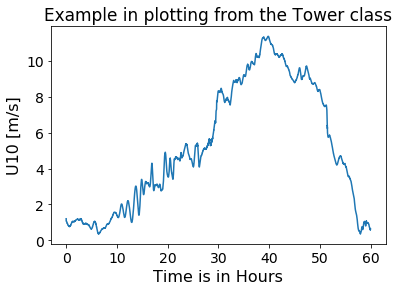

In [7]:
plt.plot(single_tower.time,single_tower.u10)
plt.xlabel('Time is in Hours',size=16)
plt.ylabel('U10 [m/s]',size=16)
plt.tick_params(labelsize=14)
plt.title('Example in plotting from the Tower class',size=17)
plt.show()

# Converting the tower class to something more useful

In [8]:
# Simulation start time:
wrf_start = '2010-05-14 12:00:00'
# Time step:
wrf_dt = 3.0

### Pandas dataframe:

In [9]:
tower_df = single_tower.to_dataframe(start_time=wrf_start,
                                     time_step=wrf_dt)

In [10]:
tower_df

qv      theta         v            ph  \
datetime            height                                               
2010-05-14 12:00:03 0       0.00458  279.69736  -1.32449      4.824175   
                    1       0.00458  279.69427  -1.32944      9.631220   
                    2       0.00457  279.69424  -1.33040     14.440640   
                    3       0.00457  279.69449  -1.33116     19.252440   
                    4       0.00457  279.69504  -1.33203     24.140880   
...                             ...        ...       ...           ...   
2010-05-17 00:00:00 81      0.00000  362.98251  11.25328  12741.466800   
                    82      0.00000  374.95776   7.36810  13453.242190   
                    83      0.00000  386.96329   3.67955  14158.848145   
                    84      0.00000  398.99356   3.37941  14857.905760   
                    85      0.00000  412.60626   1.89186  15549.568360   

                                  u            pr        w  
datetime            height                                  
2010-05-14 12:00:03 0       1.01789  101347.75781 -0.00010  
                    1       1.02538  101288.67969 -0.00030  
                    2       1.02980  101229.52344 -0.00053  
                    3       1.03472  101170.46875 -0.00075  
                    4       1.04106  101111.39844 -0.00100  
...                             ...           ...      ...  
2010-05-17 00:00:00 81      2.07947   18068.50586  0.00018  
                    82      3.18465   16191.50195  0.00684  
                    83      2.29986   14523.32031  0.00371  
                    84      1.32233   13040.52637 -0.00137  
                    85      2.55169   11722.57812 -0.00036  

[6192000 rows x 7 columns]

### Note that when converting to df, we lose the 1D variables -- if you need this capability, let us know... but a workaround is below.

## Xarray dataset:

In [11]:
tower_ds = single_tower.to_xarray(start_time=wrf_start,
                                  time_step=wrf_dt,
                                  structure='unordered') # Options for ordered or unordered will be explained when combining towers

In [12]:
tower_ds

<xarray.Dataset>
Dimensions:   (datetime: 72000, k: 86, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2010-05-14T12:00:03 ... 2010-05-17
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 76 77 78 79 80 81 82 83 84 85
  * station   (station) <U3 'FN1'
Data variables:
    qv        (datetime, k, station) float64 0.00458 0.00458 0.00457 ... 0.0 0.0
    theta     (datetime, k, station) float64 279.7 279.7 279.7 ... 399.0 412.6
    v         (datetime, k, station) float64 -1.324 -1.329 -1.33 ... 3.379 1.892
    ph        (datetime, k, station) float64 4.824 9.631 ... 1.486e+04 1.555e+04
    u         (datetime, k, station) float64 1.018 1.025 1.03 ... 1.322 2.552
    pr        (datetime, k, station) float64 1.013e+05 1.013e+05 ... 1.172e+04
    w         (datetime, k, station) float64 -0.0001 -0.0003 ... -0.00036
    i         (station) int64 147
    j         (station) int64 103
    lat       (station) float64 54.02
    lon       (station) float64 6.581
    zsurface  (station) float64 0.0
    t2        (datetime, station) float64 280.8 281.0 281.0 ... 281.8 281.8
    q2        (datetime, station) float64 0.00676 0.00518 ... 0.00652 0.00652
    u10       (datetime, station) float64 1.205 1.103 1.102 ... 0.6328 0.6332
    v10       (datetime, station) float64 -1.564 -1.432 -1.432 ... -1.752 -1.752
    psfc      (datetime, station) float64 1.014e+05 1.014e+05 ... 1.012e+05
    lwd       (datetime, station) float64 262.0 262.0 262.0 ... 272.6 272.6
    swd       (datetime, station) float64 787.9 787.9 787.9 ... 0.0 0.0 0.0
    hfx       (datetime, station) float64 7.554 4.678 4.601 ... 0.9182 0.9183
    lfx       (datetime, station) float64 1e-05 25.44 26.04 ... 4.609 4.606
    tsk       (datetime, station) float64 281.7 281.7 281.7 ... 282.0 282.0
    slttop    (datetime, station) float64 273.2 281.7 281.7 ... 282.0 282.0
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (datetime, station) float64 0.00268 0.0027 ... 0.00084 0.00083

### Converting to xarray dataset preserves all variables. Note that the height coordinate is simply the z index for the height variable (ph) which is time and height varying.

### Plotting with the height index is not ideal since our heights are generally not linearly spaced:

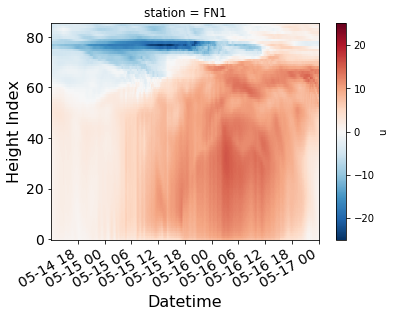

In [13]:
tower_ds.u.T.plot() # T is for 'transpose' since the first dimension will be put on the y-axis
plt.xlabel('Datetime',size=16)
plt.ylabel('Height Index',size=16)
plt.tick_params(labelsize=14)

### Getting around this is a bit tricky, but doable:

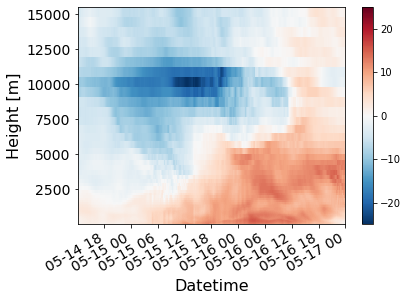

In [14]:
plt.pcolormesh(tower_ds.datetime.data, # Time on x axis
               np.squeeze(tower_ds.ph.mean(axis=0).data), # Average height on y axis
               np.squeeze(tower_ds.u.data).T, # transpose U for plot
               cmap=plt.cm.RdBu_r,norm=Normalize(-25,25))
plt.colorbar()
plt.xlabel('Datetime',size=16)
plt.xticks(rotation=30,ha='right')
plt.ylabel('Height [m]',size=16)
plt.tick_params(labelsize=14)
plt.show()

## Interpolating tslist to specific heights:
(This may take some time...)

In [15]:
tower_ds = single_tower.to_xarray(start_time=wrf_start,
                                  time_step=wrf_dt,
                                  structure='unordered',
                                  heights=[10.0,20.0,100.0],
                                  height_var='ph')

In [16]:
tower_ds

<xarray.Dataset>
Dimensions:   (datetime: 72000, height: 3, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2010-05-14T12:00:03 ... 2010-05-17
  * height    (height) float64 10.0 20.0 100.0
  * station   (station) <U3 'FN1'
Data variables:
    qv        (datetime, height, station) float64 0.004579 0.00457 ... 0.005744
    theta     (datetime, height, station) float64 279.7 279.7 ... 280.7 281.1
    v         (datetime, height, station) float64 -1.33 -1.331 ... -2.235 -3.135
    u         (datetime, height, station) float64 1.026 1.036 ... 0.7956 0.6864
    pr        (datetime, height, station) float64 1.013e+05 1.012e+05 ... 1e+05
    w         (datetime, height, station) float64 -0.0003176 ... -0.008503
    i         (station) int64 147
    j         (station) int64 103
    lat       (station) float64 54.02
    lon       (station) float64 6.581
    zsurface  (station) float64 0.0
    t2        (datetime, station) float64 280.8 281.0 281.0 ... 281.8 281.8
    q2        (datetime, station) float64 0.00676 0.00518 ... 0.00652 0.00652
    u10       (datetime, station) float64 1.205 1.103 1.102 ... 0.6328 0.6332
    v10       (datetime, station) float64 -1.564 -1.432 -1.432 ... -1.752 -1.752
    psfc      (datetime, station) float64 1.014e+05 1.014e+05 ... 1.012e+05
    lwd       (datetime, station) float64 262.0 262.0 262.0 ... 272.6 272.6
    swd       (datetime, station) float64 787.9 787.9 787.9 ... 0.0 0.0 0.0
    hfx       (datetime, station) float64 7.554 4.678 4.601 ... 0.9182 0.9183
    lfx       (datetime, station) float64 1e-05 25.44 26.04 ... 4.609 4.606
    tsk       (datetime, station) float64 281.7 281.7 281.7 ... 282.0 282.0
    slttop    (datetime, station) float64 273.2 281.7 281.7 ... 282.0 282.0
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (datetime, station) float64 0.00268 0.0027 ... 0.00084 0.00083

### Now the height coordinate variable is what we specified and all 2D vars are interpolated to these heights

### Plotting a variable:
#### Same as in xarrays

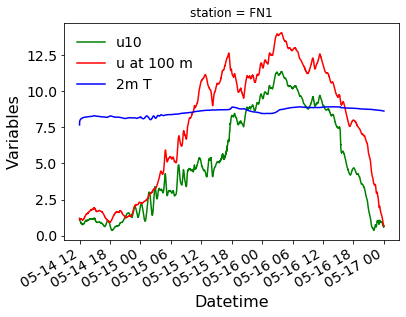

In [17]:
tower_ds.u10.plot(c='g',label='u10')
tower_ds.u.sel(height=100.0).plot(c='r',label='u at 100 m') # Selecting a specific height from the 2D variables
(tower_ds.t2 - 273.15).plot(c='b',label='2m T') # You can adjust variables by putting them in parentheses then calling plot
plt.xlabel('Datetime',size=16)
plt.ylabel('Variables',size=16)
plt.tick_params(labelsize=14)
plt.legend(frameon=False,fontsize=14,loc=2)
plt.show()

# Combine several WRF runs using combine_towers:

In [18]:
# Location of main directory with subfolders for restart data:
main_simulation_dir = '/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/'
# Array with the names of the restart directories:
restart_dirs = ['FINO_2010051412','FINO_2010051612']
# Array corresponding to start times of each restart:
wrf_start_times = ['2010-05-14 12:00:00','2010-05-16 12:00:00']

### To test, let's first read in a tower from each restart individually:

In [19]:
twrA = Tower('{}{}/{}'.format(main_simulation_dir,restart_dirs[0],twr_file_name))
twrA_ds = twrA.to_xarray(start_time=wrf_start_times[0],
                         time_step=wrf_dt,
                         structure='unordered')

twrB = Tower('{}{}/{}'.format(main_simulation_dir,restart_dirs[1],twr_file_name))
twrB_ds = twrB.to_xarray(start_time=wrf_start_times[1],
                         time_step=wrf_dt,
                         structure='unordered')

### Now read in and combine with data from the first restart overlapping the second restart:

In [20]:
twr_combined = combine_towers(fdir=main_simulation_dir,
                               restarts=restart_dirs,
                               simulation_start=wrf_start_times,
                               fname=[twr_file_name],
                               time_step=wrf_dt,
                               structure='unordered')

restart: FINO_2010051412
starting FN1.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051412/FN1.d03
restart: FINO_2010051612
starting FN1.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051612/FN1.d03


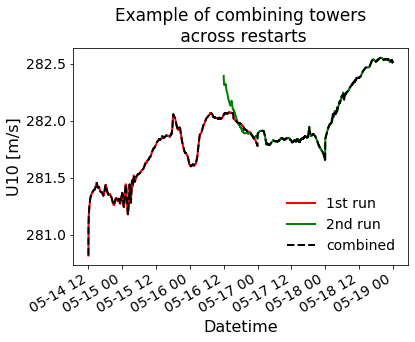

In [21]:
twrA_ds.t2.plot(c='r',lw=2.0,label='1st run')
twrB_ds.t2.plot(c='g',lw=2.0,label='2nd run')
twr_combined.t2.plot(c='k',ls='--',lw=2.0,label='combined')
plt.xlabel('Datetime',size=16)
plt.ylabel('U10 [m/s]',size=16)
plt.tick_params(labelsize=14)
plt.title('Example of combining towers\n across restarts',size=17)
plt.legend(frameon=False,fontsize=14,loc=0)
plt.show()

# Combine serveral Towers over several runs with tsout_seriesReader:
This function utilizes combine_towers as above and includes more functionality.

In [22]:
twrs_combined = tsout_seriesReader(fdir=main_simulation_dir,
                                   restarts=restart_dirs,
                                   simulation_start_time=wrf_start_times,
                                   structure='unordered',
                                   time_step=wrf_dt,
                                   domain_of_interest='d03',
                                   )

restart: FINO_2010051412
starting FN1.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051412/FN1.d03
starting FN3.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051412/FN3.d03
restart: FINO_2010051612
starting FN1.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051612/FN1.d03
starting FN3.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051612/FN3.d03


In [23]:
twrs_combined

<xarray.Dataset>
Dimensions:   (datetime: 129600, nz: 50, station: 2)
Coordinates:
    lat       (station) float64 54.02 55.19
    lon       (station) float64 6.581 7.156
    zsurface  (station) float64 0.0 0.0
  * datetime  (datetime) datetime64[ns] 2010-05-14T12:00:03 ... 2010-05-19
    k         (nz) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * station   (station) object 'FN1' 'FN3'
Dimensions without coordinates: nz
Data variables:
    qv        (datetime, nz, station) float64 0.00458 0.00404 ... 0.00744
    theta     (datetime, nz, station) float64 279.7 279.2 279.7 ... 288.8 292.0
    v         (datetime, nz, station) float64 -1.324 -2.259 ... -16.7 -14.84
    ph        (datetime, nz, station) float64 4.824 4.813 9.631 ... 953.2 964.3
    u         (datetime, nz, station) float64 1.018 2.053 1.025 ... 5.061 0.3411
    pr        (datetime, nz, station) float64 1.013e+05 1.013e+05 ... 9.103e+04
    w         (datetime, nz, station) float64 -0.0001 3e-05 ... 0.1786 0.02652
    i         (station) int64 147 175
    j         (station) int64 103 236
    t2        (datetime, station) float64 280.8 280.3 281.0 ... 282.5 282.1
    q2        (datetime, station) float64 0.00676 0.00653 ... 0.00605 0.00619
    u10       (datetime, station) float64 1.205 2.431 1.103 ... 8.393 9.85 8.392
    v10       (datetime, station) float64 -1.564 -2.672 -1.432 ... -8.813 -11.27
    psfc      (datetime, station) float64 1.014e+05 1.014e+05 ... 1.017e+05
    lwd       (datetime, station) float64 262.0 257.0 262.0 ... 276.5 297.3
    swd       (datetime, station) float64 787.9 778.9 787.9 ... 0.0 0.0 0.0
    hfx       (datetime, station) float64 7.554 10.59 4.678 ... 2.778 -5.183
    lfx       (datetime, station) float64 1e-05 -0.0 25.44 ... 49.73 81.04 49.72
    tsk       (datetime, station) float64 281.7 281.2 281.7 ... 282.6 281.9
    slttop    (datetime, station) float64 273.2 273.2 281.7 ... 282.6 281.9
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (datetime, station) float64 0.00268 0.0 0.0027 ... 0.06583 0.03098
    wspd      (datetime, nz, station) float64 1.67 3.053 1.679 ... 17.45 14.84
    wdir      (datetime, nz, station) float64 322.5 317.7 322.4 ... 343.1 358.7
Attributes:
    CREATED_FROM:  /glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526...

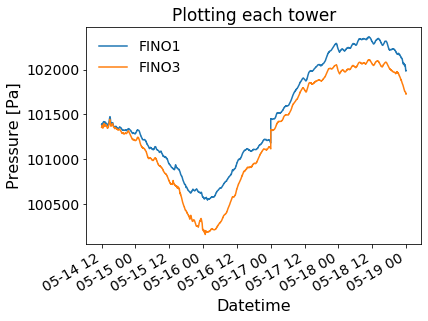

In [24]:
twrs_combined.sel(station='FN1').psfc.plot(label='FINO1')
twrs_combined.sel(station='FN3').psfc.plot(label='FINO3')
plt.legend(frameon=False,loc=0,fontsize=14)
plt.xlabel('Datetime',size=16)
plt.ylabel('Pressure [Pa]',size=16)
plt.tick_params(labelsize=14)
plt.title('Plotting each tower',size=17)
plt.show()

## Combining and interpolating:

In [25]:
twrs_combined_int = tsout_seriesReader(fdir=main_simulation_dir,
                                       restarts=restart_dirs,
                                       simulation_start_time=wrf_start_times,
                                       structure='unordered',
                                       time_step=wrf_dt,
                                       domain_of_interest='d03',
                                       heights=[50.0],
                                       height_var='ph'
                                       )

restart: FINO_2010051412
starting FN1.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051412/FN1.d03
starting FN3.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051412/FN3.d03
restart: FINO_2010051612
starting FN1.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051612/FN1.d03
starting FN3.d03
/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051612/FN3.d03


In [26]:
twrs_combined_int

<xarray.Dataset>
Dimensions:   (datetime: 129600, nz: 1, station: 2)
Coordinates:
    lat       (station) float64 54.02 55.19
    lon       (station) float64 6.581 7.156
    zsurface  (station) float64 0.0 0.0
  * datetime  (datetime) datetime64[ns] 2010-05-14T12:00:03 ... 2010-05-19
    height    (nz) float64 50.0
  * station   (station) object 'FN1' 'FN3'
Dimensions without coordinates: nz
Data variables:
    qv        (datetime, nz, station) float64 0.00455 0.003916 ... 0.005754
    theta     (datetime, nz, station) float64 279.7 279.3 279.7 ... 280.9 280.8
    v         (datetime, nz, station) float64 -1.336 -2.303 ... -10.56 -13.53
    u         (datetime, nz, station) float64 1.065 2.117 1.066 ... 11.61 9.868
    pr        (datetime, nz, station) float64 1.008e+05 1.008e+05 ... 1.012e+05
    w         (datetime, nz, station) float64 -0.002624 0.0009035 ... 0.001225
    i         (station) int64 147 175
    j         (station) int64 103 236
    t2        (datetime, station) float64 280.8 280.3 281.0 ... 282.5 282.1
    q2        (datetime, station) float64 0.00676 0.00653 ... 0.00605 0.00619
    u10       (datetime, station) float64 1.205 2.431 1.103 ... 8.393 9.85 8.392
    v10       (datetime, station) float64 -1.564 -2.672 -1.432 ... -8.813 -11.27
    psfc      (datetime, station) float64 1.014e+05 1.014e+05 ... 1.017e+05
    lwd       (datetime, station) float64 262.0 257.0 262.0 ... 276.5 297.3
    swd       (datetime, station) float64 787.9 778.9 787.9 ... 0.0 0.0 0.0
    hfx       (datetime, station) float64 7.554 10.59 4.678 ... 2.778 -5.183
    lfx       (datetime, station) float64 1e-05 -0.0 25.44 ... 49.73 81.04 49.72
    tsk       (datetime, station) float64 281.7 281.2 281.7 ... 282.6 281.9
    slttop    (datetime, station) float64 273.2 273.2 281.7 ... 282.6 281.9
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (datetime, station) float64 0.00268 0.0 0.0027 ... 0.06583 0.03098
    wspd      (datetime, nz, station) float64 1.708 3.128 1.71 ... 15.7 16.75
    wdir      (datetime, nz, station) float64 321.4 317.4 321.4 ... 312.3 323.9
Attributes:
    CREATED_FROM:  /glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526...

# Saving as a file:

In [27]:
twrs_combined_int.to_netcdf('twr_example.nc')